In [33]:
import scipy.io
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from PIL import ImageOps
from PIL import Image

mat = scipy.io.loadmat('imData.mat')

X = mat["t10_X"]
y = mat["data_Y"]

X_resize = np.zeros((1000,128,128))
y_resize = np.zeros((1000,128,128))

# resize(X,(128,128))

for i in range(len(X[:,0,0])):
    X_resize[i,:,:] = cv2.resize(X[i,:,:],(128,128))
    y_resize[i,:,:] = cv2.resize(y[i,:,:],(128,128))
    
    y_resize[i,:,:] = 0 *(y_resize[i,:,:] >= 0) + 1 *(y_resize[i,:,:] > 40) + 1 * (y_resize[i,:,:] > 170)

train_X, test_X, train_Y, test_Y = train_test_split(X_resize, y_resize, test_size=0.1)

# im = Image.fromarray(np.uint8(y_resize[1,:,:]*255))
# img = ImageOps.autocontrast(im)
# img = ImageOps.colorize(im,"blue","red",mid = "green")
# img = ImageOps.autocontrast(img)
# plt.imshow(X_resize[1,:,:])
# plt.figure()
# plt.imshow(y_resize[1,:,:])

print(np.unique(np.array(y_resize[1,:,:])))
# (train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

[0. 1. 2.]


In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

print(type(train_X[0,:,:]))

Training data shape :  (900, 128, 128) (900, 128, 128)
Testing data shape :  (100, 128, 128) (100, 128, 128)
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Ground Truth')

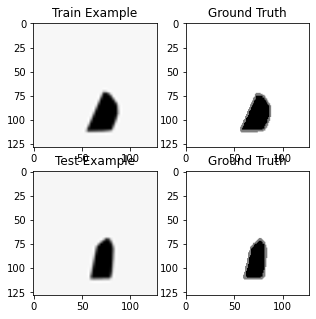

In [35]:
'''Also, take a look at what the images in your dataset:
The output of above two plots created here looks like an ankle boot, and this 
class is assigned a class label of 9. Similarly, other fashion 
products will have different labels, but similar products will have same 
labels. This means that all the 7,000 ankle boot images will have a class label of 9.'''

'''Datasets are a collection of samples of data. The data can be images, audio, text, 
matrices of numbers or even rows of an Excel spreadsheet. When doing machine learning, 
you'll usually need a ground-truth dataset. A ground-truth dataset is a regular dataset, 
but with annotations added to it. '''

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(221)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Train Example")
plt.subplot(222)
plt.imshow(train_Y[0,:,:], cmap='gray')
plt.title("Ground Truth")

# Display the first image in testing data
plt.subplot(223)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Test Example")
plt.subplot(224)
plt.imshow(test_Y[0,:,:], cmap='gray')
plt.title("Ground Truth")

In [36]:
'''Data Preprocessing

As you could see in the above plot, the images are grayscale images have pixel values 
that range from 0 to 255. Also, these images have a dimension of 50 x 50. As a result, 
you'll need to preprocess the data before you feed it into the model. '''

'''As a first step, convert each 50 x 50 image of the train and test set into a matrix of 
size 50 x 50 x 1 which is fed into the network.'''
train_X = train_X.reshape(-1, 128,128, 1)
test_X = test_X.reshape(-1, 128,128, 1)
train_X.shape, test_X.shape

((900, 128, 128, 1), (100, 128, 128, 1))

In [37]:
'''The data right now is in an int8 format, so before you feed it into the network you need to 
convert its type to float32, and you also have to rescale the pixel values in range 0 - 1 inclusive. 
Here is code to do that:'''

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/ 255
test_X = test_X / 255




In [38]:
#PARTITIONING THE DATA
'''This last step is a crucial one. In machine learning or any data specific task, 
you should partition the data correctly. For the model to generalize well, you split 
the training data into two parts, one designed for training and another one for validation. 
In this case, you will train the model on 80\% of the training data and validate it on 20\% 
of the remaining training data. This will also help to reduce overfitting since you will be 
validating the model on the data it would not have seen in training phase, which will help in 
boosting the test performance.'''

#go to Environments/your 3.7environmeny, select Not Installed from drop-down menu, search for 
#scikit-learn (vers 0.24.1), select it, klick apply button

from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

train_label = train_label.reshape(-1, 128,128, 1)
valid_label = valid_label.reshape(-1, 128,128, 1)
#For one last time let's check the shape of training and validation set.
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((720, 128, 128, 1),
 (180, 128, 128, 1),
 (720, 128, 128, 1),
 (180, 128, 128, 1))

In [39]:
import keras
from keras import layers
# from keras.layers import Resizing



def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

img_size = (128, 128)
num_classes = 3
batch_size = 32
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [40]:
import tensorflow as tf


#TRAIN THE MODEL

'''It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. 
The fit() function will return a history object; By storying the result of this function 
in fashion_train, you can use it later to plot the accuracy and loss function plots between 
training and validation which will help you to analyze your model's performance visually.'''
#just changed name here
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.compile(optimizer="rmsprop", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

tf.config.experimental.set_visible_devices([], 'GPU')



# Train the model, doing validation at the end of each epoch.
epochs = 2
fashion_train_dropout = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,callbacks = callbacks,validation_data=(valid_X, valid_label), verbose = 1)

'''This added code will save the model so that you can directly load it and not have to train it again 
for 20 epochs. This way, you can load the model later on if you need it and modify the architecture;'''
model.save("gan_model_t10_128_logits.h5py")


Train on 720 samples, validate on 180 samples
Epoch 1/2
720/720 [==============================] - 131s 182ms/step - loss: 0.6349 - accuracy: 0.9121 - val_loss: 0.6244 - val_accuracy: 0.9482
Epoch 2/2
720/720 [==============================] - 117s 163ms/step - loss: 0.5715 - accuracy: 0.9797 - val_loss: 0.6067 - val_accuracy: 0.9482


In [41]:
#ACCURACY, OVERFITTING?

'''Before, with no dropouts, after 20 epochs the training accuracy was 99% and the training loss was quite low.

It appeared that the model was overfitting, as the validation loss is 0.4396 and the validation accuracy was 92%. 
Overfitting generally corresponds to the network having memorized the training data very well but is 
not guaranteed to work on unseen data, and that is why there was a difference in the training and validation 
accuracy.

Here the training accuracy is 92.5% and the validation accuracy is 92.8%, indicating that the model does not 
overfit the dsta

Model Evaluation on the Test Set'''
#Model Evaluation Code:
test_eval = model.evaluate(test_X, test_Y.reshape(-1,128,128,1), verbose=1)  #changed to verbose=1 to show progress
print('Test loss:', test_eval)
# print('Test accuracy:', test_eval[1])

100/100 [==============================] - 3s 34ms/step
Test loss: [0.6118922710418702, 0.9429516792297363]


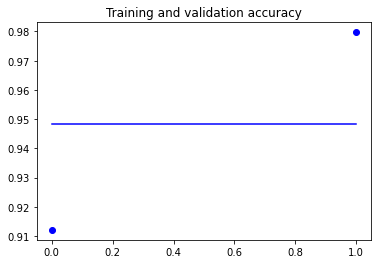

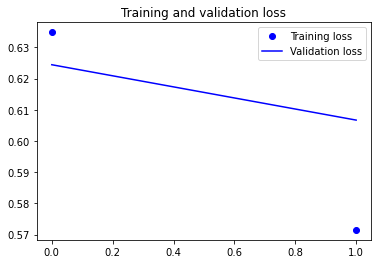

In [42]:

#accuracy = fashion_train_dropout.history['acc']
#val_accuracy = fashion_train_dropout.history['val_acc']
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
# fashion_train_dropout.history

loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
# plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [43]:
val_preds = model.predict(train_X.reshape(-1,128,128,1))


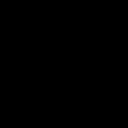

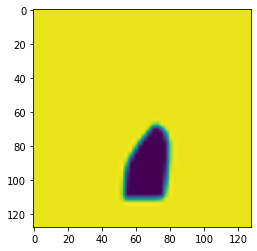

<Figure size 432x288 with 0 Axes>

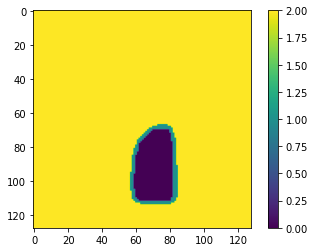

In [49]:
testInd = 100

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    plt.figure()
    display(img)
    # plt.imshow(img)

# print(new_new[0,1,1,:])

plt.figure()
plt.imshow(train_X[testInd,:,:])
# new_plot = np.zeros((128,128))
# plt.figure()
# for i in range(np.shape(new_new[0,:,:,0])[0]):
#     for j in range(np.shape(new_new[0,:,:,0])[1]):
        
#         new_plot[i,j] = np.argwhere(new_new[0,i,j,0:2] == np.min(new_new[0,i,j,0:2]))[0][0]
#         print(new_new[0,i,j,:])
    
# plt.imshow(new_plot)
display_mask(testInd)
# plt.imshow(new_new[0,:,:,1])
# plt.imshow(new_new[0,:,:,2])

plt.figure()
plt.imshow(train_Y[testInd,:,:])
plt.colorbar()

# print(np.argwhere(new_new[0,0,0,:] == np.max(new_new[0,0,0,:]))[0][0])


# np.sum(new_new[0,:,:,:],axis = 2)